# This notebook has been modified to test a dataset that comprises 4 subpopulations

In [12]:
using DiffusionMLE, Plots

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of heterogeneous single-particle tracking data.  Here, "heterogeneous" refers to the fact that the data originate from subpopulations with differing diffusion coefficients.  

The code relevant for the analysis of heterogeneous data exploits threading, so it is recommended to run the command <code>export JULIA_NUM_THREADS=n</code>, with <code>n</code> being the number of available (physical) cores, before launching Julia.  This speeds up the numerics significantly.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  The data form a $3:4:3$-mixture of trajectories generated using three distinct diffusive dynamics.  

In [13]:
include("smeared_trajectory_integrator.jl")

const M = 1000 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 100 # Number of substeps over which the trajectory is smeared out

N = [ rand(3:100) for i = 1 : M ] # Array of trajectory lengths

# Consider three subpopulations, characterized by the following parameters:
const a2_1 = 0.5
const a2_2 = 2.0
const a2_3 = 1.0
const a2_4 = 3.0
const σ2_1 = 0.1
const σ2_2 = 1.0
const σ2_3 = 10.0
const σ2_4 = 50.0

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = vcat([make_2D_data(N[1:250],N_sub,a2_1,σ2_1), 
        make_2D_data(N[251:500],N_sub,a2_2,σ2_2), 
        make_2D_data(N[501:750],N_sub,a2_3,σ2_3),
        make_2D_data(N[751:1000],N_sub,a2_4,σ2_4),]...); # Mock data set

# Analyzing the data

In [14]:
function print_results(estimates,uncertainties)
    K = size(estimates,2)
    for k = 1 : K
        println(string("a2_", k, " = ", estimates[1,k], " ± ", uncertainties[1,k]))
    end
    for k = 1 : K
        println(string("σ2_", k, " = ", estimates[2,k], " ± ", uncertainties[2,k]))
    end
    for k = 1 : K
        println(string("P_", k, " = ", estimates[3,k]))
    end
end

const N_local = 500 # Max number of expectation-maximization cycles
const N_global = 100 # Number of iterations with different initial parameters

# Ranges from which the initial values for the parameters are drawn:
a2_range = [ 0.01, 100. ]
σ2_range = [ 0.01, 100. ];

### Available cores for threading

In [15]:
using Base.Threads
println(string("Number of available cores for threading: ", nthreads()))


Number of available cores for threading: 1


### Assuming a single population

Estimates:
a2_1 = 1.6789972563355893 ± 0.04453850013437963
σ2_1 = 14.887214886299962 ± 0.10424799045200007
P_1 = 1.0

Kuiper statistic:
κ = 28.252144553292773


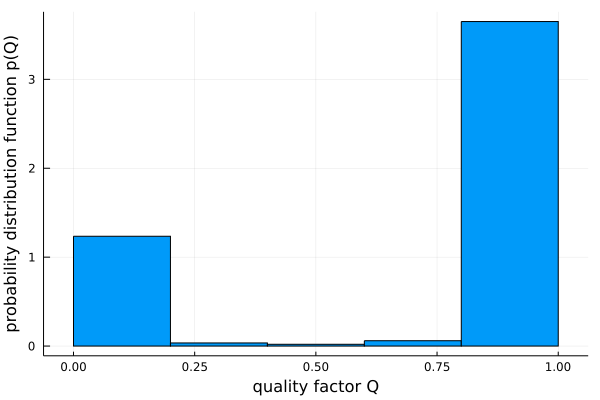

In [16]:
parameters = MLE_estimator(B,data)
parameter_matrix = reshape(vcat([parameters,[1.0]]...), 3, 1)
P1_estimates, P1_L, P1_T = local_EM_estimator!(d,M,1,N_local,parameter_matrix,B,data)
P1_uncertainties = MLE_errors(B,data,parameters)

println("Estimates:")
print_results(P1_estimates,P1_uncertainties)

Q_sub = subpopulation_analysis(P1_T,P1_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("κ = ",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, 
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The distribution of quality factors, which should be uniform, and the associated Kuiper statistic reveal that a single-population model does not suffice.  

### Assuming two subpopulations

In [17]:
P2_estimates, P2_L, P2_T = global_EM_estimator(2,N_local,N_global,a2_range,σ2_range,B,data);

Progress:  25%|███████████                              |  ETA: 0:00:26┌ Warning: NaN detected
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:176
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


In [19]:
B_sub

2-element Vector{Vector{Float64}}:
 [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666  …  0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
 [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666  …  0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]

In [18]:
B_sub, X_sub = sort_trajectories(2,P2_T,B,data)
P2_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P2_estimates[1:2,k]) for k = 1 : 2 ]...)

# println("Estimates:")
# print_results(P2_estimates,P2_uncertainties)

# Q_sub = subpopulation_analysis(P2_T,P2_estimates,B,data)
# Q = vcat(Q_sub...)

# println()

# println("Kuiper statistic:")
# println("K=",Kuiper_statistic!(Q))

# histogram(Q, normed=true, legend=false, bins=10,
#     xlabel="quality factor Q", 
#     ylabel="probability distribution function p(Q)")

2×2 Matrix{Float64}:
 0.112007  0.0123592
 0.283047  0.00846109

The Kuiper statistic is slightly better, but overall a two-population model cannot explain the data.  

### Assuming three subpopulations

In [8]:
P3_estimates, P3_L, P3_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B,data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


Estimates:
a2_1 = 0.5007678761369319 ± 0.0059142312199000555
a2_2 = 2.0167815332051955 ± 0.028314715139792602
a2_3 = 1.9584961862462467 ± 0.10826868228499197
σ2_1 = 0.09787152968825502 ± 0.002421447235297321
σ2_2 = 1.0303161707083075 ± 0.020788047144384817
σ2_3 = 29.620349666716994 ± 0.2768975491545047
P_1 = 0.249483668995402
P_2 = 0.25773438451434666
P_3 = 0.4927819464902513

Ground truth (up to permutations):
a2_1 = 0.5
a2_2 = 2.0
a2_3 = 1.0
σ2_1 = 0.1
σ2_2 = 1.0
σ2_3 = 10.0

Kuiper statistic:
K=14.045159727571987


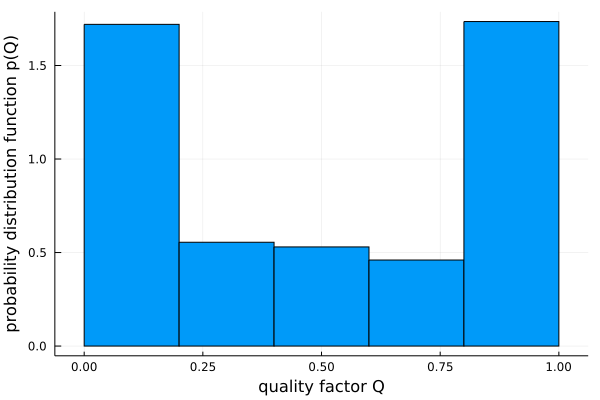

In [9]:
B_sub, X_sub = sort_trajectories(3,P3_T,B,data)
P3_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P3_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(P3_estimates,P3_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P3_T,P3_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

### Assuming four subpopulations

In [10]:
P4_estimates, P4_L, P4_T = global_EM_estimator(4,N_local,N_global,a2_range,σ2_range,B,data);

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:24┌ Warning: Failed to converge within 500 iterations
└ @ DiffusionMLE c:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\DiffusionMLE\src\em_functions.jl:185
Progress: 100%|█████████████████████████████████████████| Time: 0:05:55


Estimates:
a2_1 = 3.00738084754134 ± 0.25857361804813495
a2_2 = 2.0071132711892057 ± 0.028232879627752453
a2_3 = 0.5007660472115698 ± 0.005914211524760263
a2_4 = 0.971627295032152 ± 0.05548435975020518
σ2_1 = 50.148595632022364 ± 0.6694168544175352
σ2_2 = 1.0200243603908208 ± 0.020660047776174115
σ2_3 = 0.09787139326290219 ± 0.002421442627328294
σ2_4 = 10.11127671282437 ± 0.13393022055595138
P_1 = 0.2519821209009185
P_2 = 0.2507223970011699
P_3 = 0.24947093373004445
P_4 = 0.24782454836786738

Ground truth (up to permutations):
a2_1 = 0.5
a2_2 = 2.0
a2_3 = 1.0
a2_4 = 3.0
σ2_1 = 0.1
σ2_2 = 1.0
σ2_3 = 10.0
σ2_4 = 50.0

Kuiper statistic:
K=1.0717836446154565


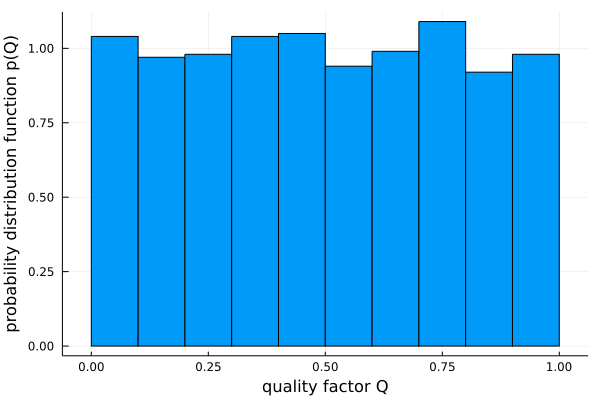

In [11]:
B_sub, X_sub = sort_trajectories(4,P4_T,B,data)
P4_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P4_estimates[1:2,k]) for k = 1 : 4 ]...)

println("Estimates:")
print_results(P4_estimates,P4_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("a2_4 = ", a2_4))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))
println(string("σ2_4 = ", σ2_4))


Q_sub = subpopulation_analysis(P4_T,P4_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The quality factors are uniformly distributed, and the Kuiper statistic evaluates close to unity for the three-population model.  

### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  

In [12]:
data

1000-element Vector{Matrix{Float64}}:
 [0.3355599489367333 0.7605959932734316; -0.3075444900129769 0.6114309782925285; … ; 0.6284256655751037 -1.89081420564497; 1.9268498868115862 -1.6542520052254412]
 [0.4188689406605414 -0.10147036224996389; -0.41392890619867556 -0.34393381513294113; … ; -1.3445818652627177 4.383473232884316; -1.9967749615167751 4.434480672757311]
 [-0.5283516860680765 0.03339802929389797; -0.05660092483985968 -0.5880806767961242; … ; 1.3463917868641344 -0.24346395739466042; 1.5906423449205427 -1.6107706278266427]
 [-0.4226964799733612 -0.35837031931589225; 0.12992952885642986 -0.6134133350767687; … ; -3.3340449029367916 2.668632582028923; -3.090387782619787 2.557047399550851]
 [-0.2530146424402996 -0.15889172027778603; 0.6980659884825697 -2.164625921934112; … ; 0.2772033956668469 0.8489854751250774; -0.35632079588213666 1.0140021742616723]
 [-0.4148955125961703 -0.6093391125478875; -0.3361082463396289 -1.108886717213816; … ; 0.2293740387585226 -1.258088116597036; 0.